In [1]:
import sys
sys.path.append('../src/')
from vi_hrg_gamma import *
from utils import c2d, hyperdist, p_hd, polar2cart, warn_tensor
from torch import autograd

In [2]:
def noise_r(x, R, rel_var=0.1):
    rs = torch.distributions.normal.Normal(x, R*rel_var).sample() 
    return torch.where(rs>R, torch.ones(rs.size()).double()*R*0.999, rs)

In [3]:
def noise_phi(x, rel_var=0.1):
    phis = torch.distributions.normal.Normal(x, 2*np.pi*rel_var).sample()
    return phis % (2*np.pi)

In [4]:
logit = lambda x: (x/(1-x)).log()

In [5]:
def grad_transform(grad):
    return 2*np.pi*grad/360

def plot_embedding(coord_file, links_file, data_file='../data/EBA_Pi.csv'):
    df_coord = pd.read_csv(coord_file, sep='\t', header=None)
    df_links = pd.read_csv(links_file, sep='\t', header=None)
    df_pi = pd.read_csv(data_file)
    col_coord = ['id', 'r', 'phi']
    df_coord.columns=col_coord 
    df_coord['phi'] = grad_transform(df_coord['phi'])
    banks = df_pi['bank_id'].unique()
    assets = df_pi['asset'].unique()
    df_banks = df_coord[df_coord['id'].isin(banks)]
    df_assets = df_coord[df_coord['id'].isin(assets)]
    banks_coord = np.array(df_banks)
    assets_coord = np.array(df_assets)
    nodes_coord = np.array(df_coord)
    links = np.array(df_links)
    
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(111, projection='polar')
    b = ax.scatter(banks_coord[:,2], banks_coord[:,1], label='banks', color='red')
    a = ax.scatter(assets_coord[:,2], assets_coord[:,1], label='assets', color='blue')
    for i in links:
        n = np.where(df_coord['id']==i[0])[0].item()
        m = np.where(df_coord['id']==i[1])[0].item()
        ax.plot(nodes_coord[[n,m],2], nodes_coord[[n,m],1], color='gray', alpha=0.05)
    ax.set_rmax(df_coord['r'].max()*1.02)
    ax.set_rticks([]) 
    ax.legend()
    plt.show()   

In [6]:
A_ = torch.zeros(7,7)
A_[1:,0]=1.
A_[0,1:]=1.
A_

tensor([[0., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])

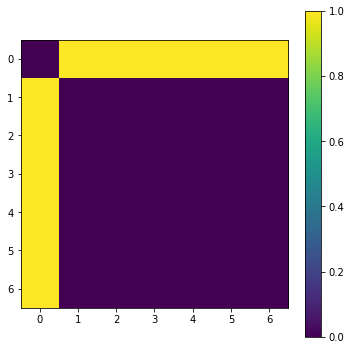

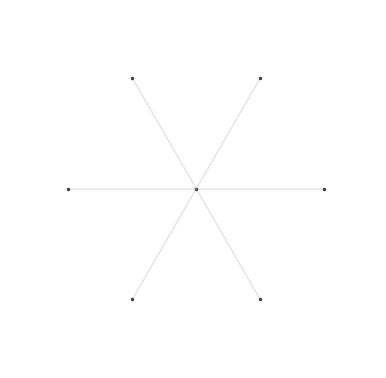

In [7]:

R = torch.tensor([5.0]).double()
alpha = 1.1
T = 0.1

G = HRG(R=R, alpha=alpha, T=T)

r = torch.cat((torch.tensor([.0]).double(),
               torch.ones(6).double()*R*0.8), dim=0)
#r = torch.cat((r, torch.ones(12)*.99*R), dim=0)
theta = torch.cat((torch.tensor([.0]),
                     torch.arange(0,2*np.pi,np.pi/3)), dim=0)
#theta = torch.cat((theta,
#                     torch.arange(np.pi/12,2*np.pi,np.pi/6)), dim=0)

N = len(r)
r_, th_, A_ = G.generate(N, r, theta)
G.show()
G.plot()

In [8]:
r_loc_init = logit(noise_r(r_, R, rel_var=0.05)/R)*R
r_scale_init = torch.ones([N]).double()
phi_loc_init = torch.cat((polar2cart(1, noise_phi(th_, 0.02)),  torch.zeros([N,1]).double()), dim=-1)
phi_loc_init.shape

torch.Size([7, 3])

In [9]:
R_conc_init = torch.tensor(1.).log()
R_scale_init = torch.tensor(1.).log()
alpha_conc_init = torch.tensor(.5).log()
alpha_scale_init = torch.tensor(.5).log()
T_init = torch.tensor([0.1,10.]).log()

In [10]:
dataloader = DataLoader(EdgesDataset(A_), batch_size=49, shuffle=True, num_workers=0)
vi = VI_HRG(7,20, init_values={'rs_loc':r_loc_init,
                                'rs_scale':r_scale_init,
                              'phis_loc':phi_loc_init,
                              'phis_scale':None, 
                              'R_conc':R_conc_init, 
                              'R_scale':R_scale_init,
                              'alpha_conc':alpha_conc_init,
                              'alpha_scale':alpha_scale_init,
                              'T':T_init})
vi.dataloader = dataloader
vi.optimizer = torch.optim.RMSprop(vi.parameters())

In [11]:
total_loss = 0
with autograd.detect_anomaly():
    #print(torch.is_anomaly_enabled())
    for idx1, idx2, data in dataloader:
        loss = - vi.elbo(idx1, idx2, data)
        vi.optimizer.zero_grad()
        loss.backward()
        vi.optimizer.step()
        print('>>>>', loss)
        total_loss += loss

../src/utils.py:120: UserWarning: dist_ has NaN in it!
  warnings.warn(str('%s has NaN in it!' % variable))
../src/utils.py:126: UserWarning: dist_ has 1 in it!
  warnings.warn(str('%s has 1 in it!' % variable))
../src/utils.py:120: UserWarning: dist has NaN in it!
  warnings.warn(str('%s has NaN in it!' % variable))
../src/utils.py:120: UserWarning: p_ has NaN in it!
  warnings.warn(str('%s has NaN in it!' % variable))
../src/utils.py:124: UserWarning: p_ has 0 in it!
  warnings.warn(str('%s has 0 in it!' % variable))
../src/utils.py:126: UserWarning: p_ has 1 in it!
  warnings.warn(str('%s has 1 in it!' % variable))
../src/utils.py:120: UserWarning: p_dist has NaN in it!
  warnings.warn(str('%s has NaN in it!' % variable))
../src/utils.py:120: UserWarning: log_pA has NaN in it!
  warnings.warn(str('%s has NaN in it!' % variable))


RuntimeError: Function 'DivBackward0' returned nan values in its 1th output.

In [ ]:
vi.train(dataloader, epochs=60)

In [ ]:
vi.alpha_conc.exp(), vi.alpha_scale.exp()

In [ ]:
vi.rs_loc, vi.rs_scale.exp()

In [ ]:
Radius(vi.rs_loc, vi.rs_scale.exp(), torch.ones([N])*R).mean

In [ ]:
vi.r_i_samples

In [ ]:
vi.R_conc.exp(), vi.R_scale.exp()

In [ ]:
p_hd_ = lambda d,R,T: (1.+((d-R)/(2.*T)).exp()).reciprocal()
phd = lambda d,R,T: 0.5 + 0.5*(-(d-R)/(4*T)).tanh()

In [ ]:
p_hd_(torch.tensor(-np.inf),R,T)

In [ ]:
phd(torch.tensor(5.1),R,T)

In [ ]:
torch.tensor([0.1,10.0]).log()

In [ ]:
x = torch.arange(0.,1.,.01)
plt.plot(x, torch.sigmoid(logit(x)))
plt.show()

In [ ]:
logit(torch.tensor(0.))

In [ ]:
l, n, m = 3, 4, 5
broadcast = torch.ones([l,n])

In [ ]:
torch.rand(m).expand(n,m).shape

In [ ]:
torch.arange(n).expand(m,n)

In [ ]:
torch.ones([l,n])

In [ ]:
torch.tensor(np.pi*2).log()

In [ ]:
arcosh = lambda x: (torch.clamp(x, min=1.) + (torch.clamp(x, min=1.)**2 - 1).sqrt())
arcosh(torch.arange(0.,2., .1))

In [ ]:
torch.clamp(x, min=1.)